In [1]:
import gc
import glob
import os
from os import path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

from collections import Counter, defaultdict
from functools import partial
from math import sqrt
import time
from functools import reduce
from numba import cuda
import math
import random
from math import exp
import pylab
from scipy.signal import savgol_filter

import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
import lightgbm as lgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score, mean_squared_error, roc_auc_score
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.signal import find_peaks

import keras
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, AveragePooling1D, \
        concatenate, BatchNormalization, Activation, Dropout, Embedding, Reshape, GaussianNoise, GaussianDropout, \
        Flatten
from keras.callbacks import LearningRateScheduler
from keras.optimizers import *
from keras.initializers import glorot_normal
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

%matplotlib inline

np.random.seed(seed=1)
warnings.filterwarnings('ignore')

split_char = '/'

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
df_test = test.drop('ID_code', axis=1).values
df_train = train.drop(['ID_code', 'target'], axis=1).values

In [3]:
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        tr[col] = tr[col]*(-1)
        te[col] = te[col]*(-1)
    return tr,te


In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
fold_split = folds.split(X, y)

idx_trns = []
idx_vals = []
for idx_trn, idx_val in fold_split:
    idx_trns.append(idx_trn)
    idx_vals.append(idx_val)
    
np.save('../input/train_kfolds.npy', np.array(idx_trns))
np.save('../input/val_kfolds.npy', np.array(idx_vals))

In [412]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)
y = train['target']

for col in X.columns:
    col_std =  X[col].std()
    col_mean = X[col].mean()
    X[col] = (X[col] - col_mean) / col_std
    X_test[col] = (X_test[col] - col_mean) / col_std
    
X, X_test = reverse(X, X_test)

In [8]:
unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm(range(df_test.shape[1])):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

100%|██████████| 200/200 [00:03<00:00, 52.16it/s]


100000
100000


In [413]:
X_real = X_test.iloc[real_samples_indexes]
X_fake = X_test.iloc[synthetic_samples_indexes]

In [401]:
X_all = pd.concat([X, X_test], axis=0).reset_index(drop=True)

In [414]:
X_reals = pd.concat([X, X_real], axis=0).reset_index(drop=True)
X_all = pd.concat([X, X_test], axis=0).reset_index(drop=True)

In [415]:
unique_df = pd.DataFrame()
for i in range(200):
    c = 'var_{}'.format(i)
    gb = X_reals.groupby(c).aggregate({c:'sum'})
    gb.columns = ['var_sum']
    gb = gb.reset_index()
    gb2 = X_all.merge(gb, on=c, how='left')['var_sum']
    unique_df[c+'_gb'] = gb2

In [416]:
X_all = pd.concat([X_all, unique_df], axis=1)

In [417]:
X_all.shape

(400000, 400)

In [ ]:
# for i in range(200):
#     c = 'var_{}'.format(i)
#     gb = X_all.groupby(c).aggregate({c:'sum'})
#     gb.columns = ['var_sum']
#     gb = gb.reset_index()
#     print(gb.shape)
#     gb2 = X_all.merge(gb, on=c, how='left')['var_sum']
    
# #     X[c+'_gb'] = gb2
#     sns.distplot(gb2.iloc[:100000])
#     sns.distplot(gb2.iloc[100000:400000])
#     plt.show()

In [504]:
for i in range(200):
    c = 'var_{}'.format(i)
    X_all[c+'_idx'] = pd.Categorical(X_all[c]).codes
    categories = pd.Series(X_all[c+'_idx']).value_counts()
    X_all[c+'_idx_count'] = X_all[c+'_idx'].map(categories)

In [509]:
X_all = X_all.iloc[:, :400]

In [510]:
X = X_all.iloc[:200000,:]
X_test = X_all.iloc[200000:400000,:]
# X_test_fake = X_all.iloc[300000:,:]

In [16]:
#100k examples have at least one unique

df_test_real = df_test[real_samples_indexes].copy()

generator_for_each_synthetic_sample = []
# Using 20,000 samples should be enough. 
# You can use all of the 100,000 and get the same results (but 5 times slower)
for cur_sample_index in tqdm(synthetic_samples_indexes[:2000]):
    
    # for each "fake" example...
    cur_synthetic_sample = df_test[cur_sample_index]
    
    # get a mask of which values have a duplicate
    potential_generators = df_train == cur_synthetic_sample


    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    
    # find columns that have only one other duplicate value. santander used unique vals for duplicates
    features_mask = np.sum(potential_generators, axis=0) == 1

    # for the possible vars, mask TRUE if any values are TRUE
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)

    # get the real test samples that played a part in "generating" fake samples
    verified_generators_for_sample = real_samples_indexes[np.argwhere(verified_generators_mask)[:, 0]]

    # add it to the list as a set
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))


  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: index 110769 is out of bounds for axis 1 with size 100000

In [70]:

# all samples in public LB are "linked" to first sample
public_LB = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_LB.intersection(x):
        public_LB = public_LB.union(x)

# all samples in public LB are "linked" to fsecond sample
private_LB = generator_for_each_synthetic_sample[1]
for x in tqdm(generator_for_each_synthetic_sample):
    if private_LB.intersection(x):
        private_LB = private_LB.union(x)
        
print(len(public_LB))
print(len(private_LB))

100%|██████████| 20000/20000 [00:08<00:00, 2412.66it/s]

50000
50000


In [80]:
np.save('public_LB.npy', public_LB)

In [12]:
plb = test.iloc[public_LB]

In [82]:
lb = test.iloc[list(private_LB)]

In [500]:
for i in range(200):
    c = 'var_{}'.format(i)
    hist, bin_edges = np.histogram(X_all[c], bins=800, density=False, range=(-4.0, 4.0))

    X_all[c+'_freq'] = hist[np.minimum(np.searchsorted(bin_edges, X_all[c])-1, 799)]
#     X_test[c+'_freq'] = hist[np.minimum(np.searchsorted(bin_edges, X_test[c])-1, 799)]

In [140]:
X = X_all.iloc[:200000]
X_test = X_all.iloc[200000:]

In [160]:
def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)

    p_right[p_right>=y.shape[0]] = y.shape[0]-1

    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    
    
    return (y[p_right]-y[p_left])

def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    
    
    # get sum and count of 
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = np.nan

    return dg['res'].values

def get_pdfs(tr, lab, x_query=None):
    y = []
    tr['target'] = lab
    for i in range(200):
        name = 'var_%d'%i
        res = get_pdf(tr,name, x_query=x_query)
        y.append(res)
    df = pd.DataFrame(np.vstack(y))
    return df.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1).as_matrix()

In [161]:
def shuffle_col_vals(x1):
    rand_x = np.array([np.random.choice(x1.shape[0], size=x1.shape[0], replace=False) for i in range(x1.shape[1])]).T
    grid = np.indices(x1.shape)
    rand_y = grid[1]
    return x1[(rand_x, rand_y)]

def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [344]:
rmin,rmax,res = -5.0, 5.0, 501
x_query = np.linspace(rmin,rmax,res)

def compute_features_for_folds(X, y, X_test):
    num_folds = len(idx_trns)
    feature_folds = {'train':[], 'val':[], 'test':[]}
    for fold_n, (idx_trn, idx_val) in enumerate(zip(idx_trns, idx_vals)):
        print('\n Computing features for fold {}'.format(fold_n+1))
        
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]
        y_trn = y.iloc[idx_trn]
        y_val = y.iloc[idx_val]
        
#         pdfs = get_pdfs(X_trn, y, x_query)
#         X_trn = X_trn.drop('target', axis=1)
        
        X_trn_f = pd.DataFrame()
        X_val_f = pd.DataFrame()
        X_test_f = pd.DataFrame()
        
        
        for i in range(200):
            c = 'var_{}'.format(i)
            gb = X.groupby(c).aggregate({c:'sum'})
            gb.columns = ['var_sum']
            gb = gb.reset_index()
            gb2 = X.merge(gb, on=c, how='left')['var_sum']
            X[c+'_gb'] = gb2
        
#         for i in range(200):
#             X_trn_f['var_{}_pdf'.format(i)] = pdfs[i][np.searchsorted(x_query, X_trn['var_{}'.format(i)])]
#             X_val_f['var_{}_pdf'.format(i)] = pdfs[i][np.searchsorted(x_query, X_val['var_{}'.format(i)])]
#             X_test_f['var_{}_pdf'.format(i)] = pdfs[i][np.searchsorted(x_query, X_test['var_{}'.format(i)])]
            
#         X_trn_f['pdf_sum'] = X_trn_f.sum(axis=1)
#         X_val_f['pdf_sum'] = X_val_f.sum(axis=1)
#         X_test_f['pdf_sum'] = X_test_f.sum(axis=1)
        
#         X_trn_f['pdf_x'] = X_trn_f.iloc[:, :200].apply(np.log).sum(axis=1)
#         X_val_f['pdf_x'] = X_val_f.iloc[:, :200].apply(np.log).sum(axis=1)
#         X_test_f['pdf_x'] = X_test_f.iloc[:, :200].apply(np.log).sum(axis=1)
  
#         X_trn_f['freq_sum'] = np.zeros(X_trn.shape[0])
#         X_val_f['freq_sum'] = np.zeros(X_val.shape[0])
#         X_test_f['freq_sum'] = np.zeros(X_test.shape[0])

        
#         X_trn_f['dev_sum'] = np.zeros(X_trn.shape[0])
#         X_val_f['dev_sum'] = np.zeros(X_val.shape[0])
#         X_test_f['dev_sum'] = np.zeros(X_test.shape[0])

        for i in range(200):
            c = 'var_{}'.format(i)
            hist, bin_edges = np.histogram(X_trn[c], bins=800, density=False, range=(-4.0, 4.0))

#             hist2 = hist / hist[::-1]

            X_trn_f[c+'_freq'] = hist[np.minimum(np.searchsorted(bin_edges, X_trn[c])-1, 799)]
            X_val_f[c+'_freq'] = hist[np.minimum(np.searchsorted(bin_edges, X_val[c])-1, 799)]
            X_test_f[c+'_freq'] = hist[np.minimum(np.searchsorted(bin_edges, X_test[c])-1, 799)]
            
#             hist, bin_edges = np.histogram(X_trn_f[c+'_freq'], bins=100, density=False)
#             X_trn_f[c+'_freq2'] = hist[np.searchsorted(bin_edges, X_trn[c])-1]
#             X_val_f[c+'_freq2'] = hist[np.minimum(np.searchsorted(bin_edges, X_val[c])-1, 799)]
#             X_test_f[c+'_freq2'] = hist[np.minimum(np.searchsorted(bin_edges, X_test[c])-1, 799)]
            
            
#             X_trn_f[c+'_freq2'] = hist2[np.minimum(np.searchsorted(bin_edges, X_trn[c])-1,1999)]
#             X_val_f[c+'_freq2'] = hist2[np.minimum(np.searchsorted(bin_edges, X_val[c])-1, 1999)]
#             X_test_f[c+'_freq2'] = hist2[np.minimum(np.searchsorted(bin_edges, X_test[c])-1, 1999)]
            
#             X_trn_f['freq_sum'] += X_trn_f[c+'_freq']
#             X_val_f['freq_sum'] += X_val_f[c+'_freq']
#             X_test_f['freq_sum'] += X_test_f[c+'_freq']
            
#             sf = savgol_filter(hist, 31, 4, mode='interp')
#             sf2 = savgol_filter(hist, 5, 2, mode='interp')
#             dev = sf2-sf
#             X_trn_f[c+'_dev'] = dev[np.searchsorted(bin_edges, X_trn[c])-1]
#             X_val_f[c+'_dev'] = dev[np.minimum(np.searchsorted(bin_edges, X_val[c])-1, 99)]
#             X_test_f[c+'_dev'] = dev[np.minimum(np.searchsorted(bin_edges, X_test[c])-1, 99)]
            
#             X_trn_f['dev_sum'] += X_trn_f[c+'_dev']
#             X_val_f['dev_sum'] += X_val_f[c+'_dev']
#             X_test_f['dev_sum'] += X_test_f[c+'_dev']
        
#         for col in X_trn_f.columns:
#             X_trn_f[col] = (X_trn_f[col] - X_trn_f[col].mean()) / X_trn_f[col].std()
#             X_val_f[col] = (X_val_f[col] - X_val_f[col].mean()) / X_val_f[col].std()
#             X_test_f[col] = (X_test_f[col] - X_test_f[col].mean()) / X_test_f[col].std()
        
        feature_folds['train'].append(X_trn_f)
        feature_folds['val'].append(X_val_f)
        feature_folds['test'].append(X_test_f)
        
    return feature_folds
            
            

In [141]:
ff = compute_features_for_folds(X, y, X_test)

NameError: name 'compute_features_for_folds' is not defined

In [443]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha=.25
    epsilon = K.epsilon()
    pt_1 = y_pred * y_true
    pt_1 = K.clip(pt_1, epsilon, 1-epsilon)
    CE_1 = -K.log(pt_1)
    FL_1 = alpha* K.pow(1-pt_1, gamma) * CE_1
    
    pt_0 = (1-y_pred) * (1-y_true)
    pt_0 = K.clip(pt_0, epsilon, 1-epsilon)
    CE_0 = -K.log(pt_0)
    FL_0 = (1-alpha)* K.pow(1-pt_0, gamma) * CE_0
    
    loss = K.sum(FL_1, axis=1) + K.sum(FL_0, axis=1)
    return loss

def dense_block(x, dense_dim, dropout, activation):
    x = Dense(dense_dim)(x)
#     x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    return x


def create_nn(n_input, n_hidden, dropout=0.0, activation='relu'):
    inp = Input((n_input,))
    x = inp
    x = Lambda(lambda x: K.expand_dims(x, axis=-1))(x)
    x = dense_block(x, n_hidden, dropout, activation)
    x = Flatten()(x)
#     x = dense_block(x, 8, dropout, activation)
    out = dense_block(x, 1, dropout, 'sigmoid')
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[auc])
    return model

In [458]:
def train_and_test_model(X, y, X_test, params, fold_features=None, model_type='lgb',
                         n_hidden=16, dropout=1.0, activation='relu'):
    result_dict = {
        'val_preds': np.zeros(len(X)),
        'test_preds': None,
        'val_folds': [],
        'test_folds': []
    }
    
    if X_test is not None:
        result_dict['test_preds'] = np.zeros(len(X_test))
        X_test_r = X_test.copy()
    
    num_folds = len(idx_trns)
    
    for fold_n, (idx_trn, idx_val) in enumerate(zip(idx_trns, idx_vals)):
        print('\n Fold {}'.format(fold_n+1))
        
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]
        y_trn = y.iloc[idx_trn]
        y_val = y.iloc[idx_val]

        if fold_features is not None:
            X_trn = pd.concat([X_trn.reset_index(drop=True), fold_features['train'][fold_n]], axis=1)
            X_val = pd.concat([X_val.reset_index(drop=True), fold_features['val'][fold_n]], axis=1)
            if X_test is not None:
                X_test = pd.concat([X_test_r.reset_index(drop=True), fold_features['test'][fold_n]], axis=1)
        
#         print('Augmenting fold...')
#         X_trn, y_trn = augment(X_trn.values, y_trn.values, t=4)
#         X_trn = pd.DataFrame(X_trn)
#         X_trn = X_trn.add_prefix('var_')
# 
        if model_type == 'lgb':
            dat_trn = lgb.Dataset(X_trn, label=y_trn)
            dat_val = lgb.Dataset(X_val, label=y_val)

            start_time = time.time()
            model = lgb.train(params, dat_trn, valid_sets=[dat_trn, dat_val], verbose_eval=1000)

            print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))

            y_hat_val = model.predict(X_val, num_iteration=model.best_iteration)
            result_dict['val_preds'][idx_val] = y_hat_val
            result_dict['val_folds'].append(y_hat_val)

            feature_df = pd.DataFrame({'feature': X_trn.columns, 'importance': model.feature_importance()})
            sorted_feat = feature_df.sort_values(by='importance', ascending=False)
            plt.figure(figsize=(10, 10))
            sns.barplot(x='importance', y='feature', data=sorted_feat[:50])
    #             print('Most useless features: ')
    #             print(sorted_feat[-20:])
            plt.title('LGB Features for fold')
            plt.show()

            if X_test is not None:
                y_hat = model.predict(X_test, num_iteration=model.best_iteration) / num_folds
                result_dict['test_preds'] += y_hat
                result_dict['test_folds'].append(y_hat)
                
        elif model_type == 'xgb':
            
            dat_trn = xgb.DMatrix(data=X_trn, label=y_trn, feature_names=X_trn.columns)
            dat_val = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)
            watchlist = [(dat_trn, 'train'), (dat_val, 'valid')]
            model = xgb.train(dtrain=dat_trn, num_boost_round=20000, evals=watchlist,
                             early_stopping_rounds=200, verbose_eval=500, params=params)

            y_hat_val = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
            result_dict['val_preds'][idx_val] = y_hat_val
            result_dict['val_folds'].append(y_hat_val)
            
            if X_test is not None:
                y_hat = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)
                result_dict['test_folds'].append(y_hat)
                result_dict['test_preds'] += y_hat

            
        elif model_type == 'nn':
            batch_size=128
            reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001)

            early = EarlyStopping(monitor="val_loss", 
                              mode="min", 
                              patience=9)

            callbacks_list = [early]


            nn = create_nn(X_trn.shape[1], n_hidden, dropout=dropout, activation=activation)
            nn.summary()
            nn.fit(X_trn, y_trn, batch_size=batch_size, epochs=60, verbose=2, validation_data=(X_val, y_val), callbacks=callbacks_list)
            result_dict['val_preds'][idx_val] = nn.predict(X_val, batch_size=batch_size)[:,0]
            
            
            if X_test is not None:
                result_dict['test_preds'] += nn.predict(X_test, batch_size=batch_size)[:,0] / 5
            
    return result_dict
        

In [511]:
lgb_params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.2,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.02,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'max_bin': 63,
    'metric':'auc',
#     'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 3,
    'num_threads': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_boost_round': 20000,
    'early_stopping_rounds': 500
}

xgb_params = {
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'seed': 1,
    'max_depth': 2,
    'min_child_weight': 1,
    'eta':0.02,
    'subsample': 0.2,
    'colsample_bytree': 0.05, 
    'colsample_bylevel': 0.2,
    'max_bin': 127,
    'tree_method': 'auto',
    'silent': 1,
}

In [460]:
nn_res = train_and_test_model(X, y, X_test, lgb_params, None, model_type='nn')


 Fold 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 400)               0         
_________________________________________________________________
lambda_22 (Lambda)           (None, 400, 1)            0         
_________________________________________________________________
dense_53 (Dense)             (None, 400, 16)           32        
_________________________________________________________________
activation_53 (Activation)   (None, 400, 16)           0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 400, 16)           0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 6401      
_

KeyboardInterrupt: 

In [461]:
xgb_res = train_and_test_model(X, y, X_test, xgb_params, None, model_type='xgb')


 Fold 1
[0]	train-auc:0.538191	valid-auc:0.535611
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[500]	train-auc:0.884853	valid-auc:0.87461
[1000]	train-auc:0.894468	valid-auc:0.883284
[1500]	train-auc:0.899299	valid-auc:0.887685
[2000]	train-auc:0.90367	valid-auc:0.891431
[2500]	train-auc:0.906936	valid-auc:0.894305
[3000]	train-auc:0.910083	valid-auc:0.897101
[3500]	train-auc:0.912678	valid-auc:0.899199
[4000]	train-auc:0.914954	valid-auc:0.901087
[4500]	train-auc:0.917027	valid-auc:0.902663
[5000]	train-auc:0.918838	valid-auc:0.904035
[5500]	train-auc:0.920464	valid-auc:0.905053
[6000]	train-auc:0.92195	valid-auc:0.906042
[6500]	train-auc:0.923335	valid-auc:0.906732
[7000]	train-auc:0.924509	valid-auc:0.907296
[7500]	train-auc:0.92555	valid-auc:0.907686
[8000]	train-auc:0.926595	valid-auc:0.908111
[8500]	train-auc:0.927478	valid-auc:0.908509
[9000]	train-auc:0.928399	valid-auc:0.908888



 Fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.871218	valid_1's auc: 0.864593
[2000]	training's auc: 0.883729	valid_1's auc: 0.877467
[3000]	training's auc: 0.890832	valid_1's auc: 0.88426
[4000]	training's auc: 0.896642	valid_1's auc: 0.890289
[5000]	training's auc: 0.901013	valid_1's auc: 0.894456
[6000]	training's auc: 0.904634	valid_1's auc: 0.897775
[7000]	training's auc: 0.907576	valid_1's auc: 0.900643
[8000]	training's auc: 0.909919	valid_1's auc: 0.903056
[9000]	training's auc: 0.912027	valid_1's auc: 0.905039
[10000]	training's auc: 0.913813	valid_1's auc: 0.90668
[11000]	training's auc: 0.915317	valid_1's auc: 0.907932
[12000]	training's auc: 0.916561	valid_1's auc: 0.908971
[13000]	training's auc: 0.91767	valid_1's auc: 0.909783
[14000]	training's auc: 0.918647	valid_1's auc: 0.91048
[15000]	training's auc: 0.919608	valid_1's auc: 0.911146
[16000]	training's auc: 0.920476	valid_1's auc: 0.911568
[17000]	training's auc: 0.921

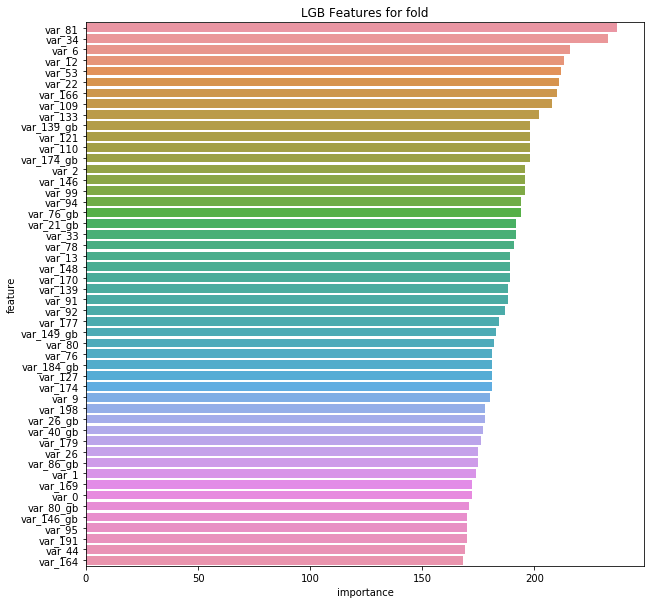


 Fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.871192	valid_1's auc: 0.864227
[2000]	training's auc: 0.884064	valid_1's auc: 0.876527
[3000]	training's auc: 0.891177	valid_1's auc: 0.883837
[4000]	training's auc: 0.897019	valid_1's auc: 0.889901
[5000]	training's auc: 0.901439	valid_1's auc: 0.894044
[6000]	training's auc: 0.905274	valid_1's auc: 0.897552
[7000]	training's auc: 0.908234	valid_1's auc: 0.900241
[8000]	training's auc: 0.910734	valid_1's auc: 0.902468
[9000]	training's auc: 0.912732	valid_1's auc: 0.904192
[10000]	training's auc: 0.91464	valid_1's auc: 0.905743
[11000]	training's auc: 0.916148	valid_1's auc: 0.906827
[12000]	training's auc: 0.91742	valid_1's auc: 0.907612
[13000]	training's auc: 0.918594	valid_1's auc: 0.908306
[14000]	training's auc: 0.919634	valid_1's auc: 0.908823
[15000]	training's auc: 0.920529	valid_1's auc: 0.909156
[16000]	training's auc: 0.921397	valid_1's auc: 0.909461
[17000]	training's auc: 0.9

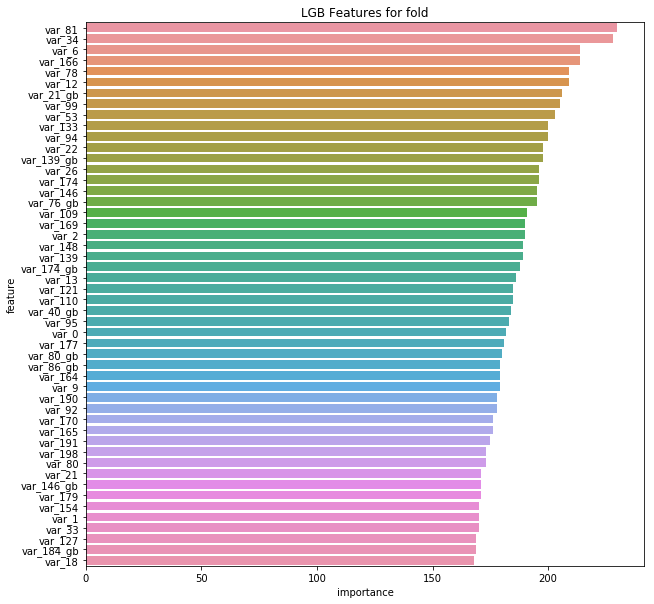


 Fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.871307	valid_1's auc: 0.869939
[2000]	training's auc: 0.883501	valid_1's auc: 0.881624
[3000]	training's auc: 0.890467	valid_1's auc: 0.887992
[4000]	training's auc: 0.896393	valid_1's auc: 0.892875
[5000]	training's auc: 0.900993	valid_1's auc: 0.896866
[6000]	training's auc: 0.904763	valid_1's auc: 0.900117
[7000]	training's auc: 0.907823	valid_1's auc: 0.902699
[8000]	training's auc: 0.910378	valid_1's auc: 0.90477
[9000]	training's auc: 0.912323	valid_1's auc: 0.906361
[10000]	training's auc: 0.914137	valid_1's auc: 0.90756
[11000]	training's auc: 0.915642	valid_1's auc: 0.90858
[12000]	training's auc: 0.916939	valid_1's auc: 0.909398
[13000]	training's auc: 0.918068	valid_1's auc: 0.910158
[14000]	training's auc: 0.919118	valid_1's auc: 0.910652
[15000]	training's auc: 0.92003	valid_1's auc: 0.91104
[16000]	training's auc: 0.920863	valid_1's auc: 0.911323
[17000]	training's auc: 0.9217

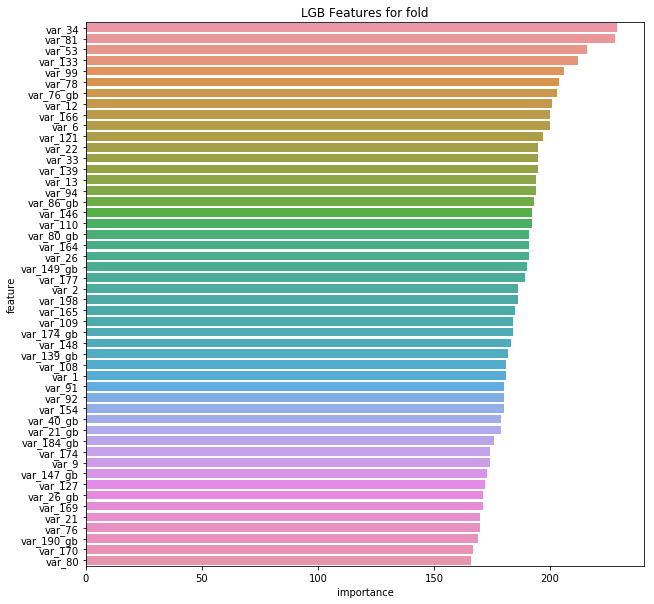


 Fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.871091	valid_1's auc: 0.865427
[2000]	training's auc: 0.884009	valid_1's auc: 0.876566
[3000]	training's auc: 0.891949	valid_1's auc: 0.883478
[4000]	training's auc: 0.897744	valid_1's auc: 0.887872
[5000]	training's auc: 0.902139	valid_1's auc: 0.891607
[6000]	training's auc: 0.906017	valid_1's auc: 0.894543
[7000]	training's auc: 0.909052	valid_1's auc: 0.896799
[8000]	training's auc: 0.911497	valid_1's auc: 0.898618
[9000]	training's auc: 0.913651	valid_1's auc: 0.900053
[10000]	training's auc: 0.915454	valid_1's auc: 0.901379
[11000]	training's auc: 0.917043	valid_1's auc: 0.902303
[12000]	training's auc: 0.918368	valid_1's auc: 0.90306
[13000]	training's auc: 0.919511	valid_1's auc: 0.903584
[14000]	training's auc: 0.920489	valid_1's auc: 0.904063
[15000]	training's auc: 0.921392	valid_1's auc: 0.904418
[16000]	training's auc: 0.922215	valid_1's auc: 0.90477
[17000]	training's auc: 0.9

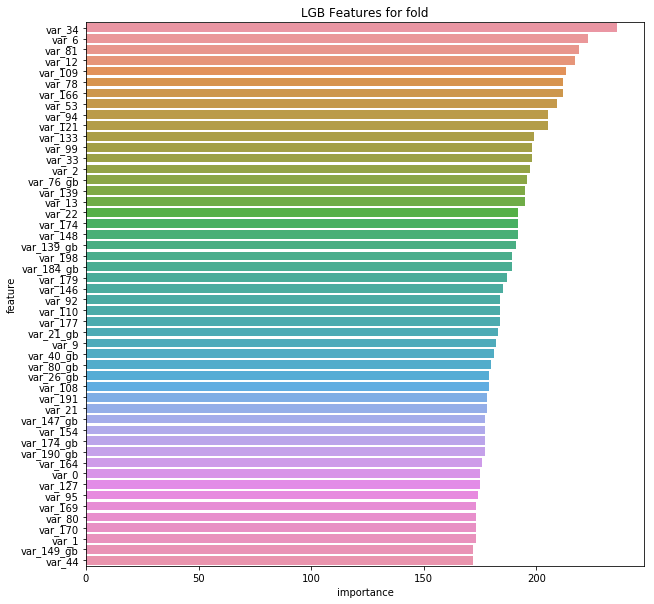


 Fold 5
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.871731	valid_1's auc: 0.862056
[2000]	training's auc: 0.884441	valid_1's auc: 0.874858
[3000]	training's auc: 0.891724	valid_1's auc: 0.881834
[4000]	training's auc: 0.897363	valid_1's auc: 0.887282
[5000]	training's auc: 0.901968	valid_1's auc: 0.89166
[6000]	training's auc: 0.905639	valid_1's auc: 0.895037
[7000]	training's auc: 0.908771	valid_1's auc: 0.897775
[8000]	training's auc: 0.911187	valid_1's auc: 0.899776
[9000]	training's auc: 0.913168	valid_1's auc: 0.901285
[10000]	training's auc: 0.914888	valid_1's auc: 0.902636
[11000]	training's auc: 0.916354	valid_1's auc: 0.903735
[12000]	training's auc: 0.917708	valid_1's auc: 0.904676
[13000]	training's auc: 0.918901	valid_1's auc: 0.905477
[14000]	training's auc: 0.919887	valid_1's auc: 0.906227
[15000]	training's auc: 0.920832	valid_1's auc: 0.906691
[16000]	training's auc: 0.921643	valid_1's auc: 0.907056
[17000]	training's auc: 0.

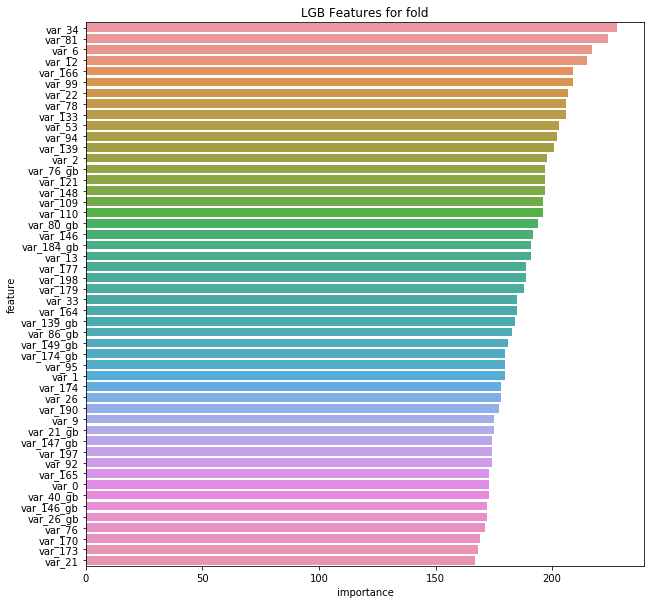

In [512]:
lgb_res =train_and_test_model(X, y, X_test, lgb_params, None, model_type='lgb')

In [462]:
roc_auc_score(train['target'], nn_res['val_preds'])

0.90148679913023799

In [464]:
roc_auc_score(train['target'], xgb_res['val_preds'])

0.90769776128675639

In [538]:
roc_auc_score(train['target'], lgb_res['val_preds'])

0.90970442124337936

In [533]:
roc_auc_score(train['target'], 0.5*lgb_res['val_preds']+0.1*nn_res['val_preds'])

0.91031171249493503

In [477]:
level1_df = pd.DataFrame({'lgb':lgb_res['val_preds'], 'nn':nn_res['val_preds'], 'xgb':xgb_res['val_preds']})
level1_df_test = pd.DataFrame({'lgb':lgb_res['test_preds'], 'nn':nn_res['test_preds'], 'xgb':xgb_res['test_preds']})

In [492]:
def train_and_test_sklearn(X, y, X_test=None, model=LogisticRegression):
    result_dict = {
        'val_preds': np.zeros(len(X)),
        'test_preds': None,
    }
    
    if X_test is not None:
        result_dict['test_preds'] = np.zeros(len(X_test))
    
    num_folds = len(idx_trns)
    for fold_n, (idx_trn, idx_val) in enumerate(zip(idx_trns, idx_vals)):
        print('\n Fold {}'.format(fold_n+1))
        
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]
        y_trn = y.iloc[idx_trn]
        y_val = y.iloc[idx_val]

        start_time = time.time()
        m = model(max_iter=1000, n_jobs=-1)
        m.fit(X_trn, y_trn)
        print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))
        
        result_dict['val_preds'][idx_val] = m.predict_proba(X_val)[:, 1]
        
        print('ROC AUC estimate: {0:.5f}'.format(roc_auc_score(y_val, result_dict['val_preds'][idx_val])))
        
        
        if X_test is not None:
            result_dict['test_preds'] += m.predict(X_test) / num_folds
            
    return result_dict

In [493]:
l1_res = train_and_test_sklearn(level1_df, y, level1_df_test)


 Fold 1
Training took 0.00 minutes.
ROC AUC estimate: 0.91211

 Fold 2
Training took 0.00 minutes.
ROC AUC estimate: 0.91040

 Fold 3
Training took 0.00 minutes.
ROC AUC estimate: 0.91260

 Fold 4
Training took 0.00 minutes.
ROC AUC estimate: 0.90711

 Fold 5
Training took 0.00 minutes.
ROC AUC estimate: 0.90690


In [489]:
level1_params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.2,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'max_bin': 127,
    'metric':'auc',
#     'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_boost_round': 20000,
    'early_stopping_rounds': 100
}


 Fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[581]	training's auc: 0.911414	valid_1's auc: 0.914614
Training took 0.08 minutes.


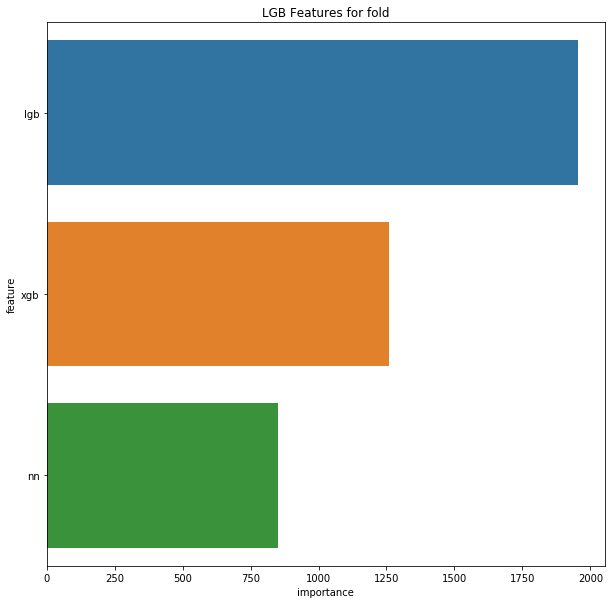


 Fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[745]	training's auc: 0.912262	valid_1's auc: 0.912105
Training took 0.12 minutes.


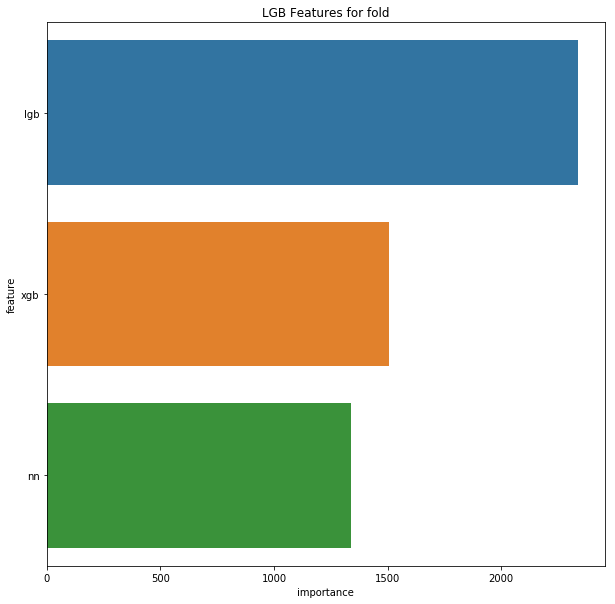


 Fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[331]	training's auc: 0.911608	valid_1's auc: 0.913833
Training took 0.05 minutes.


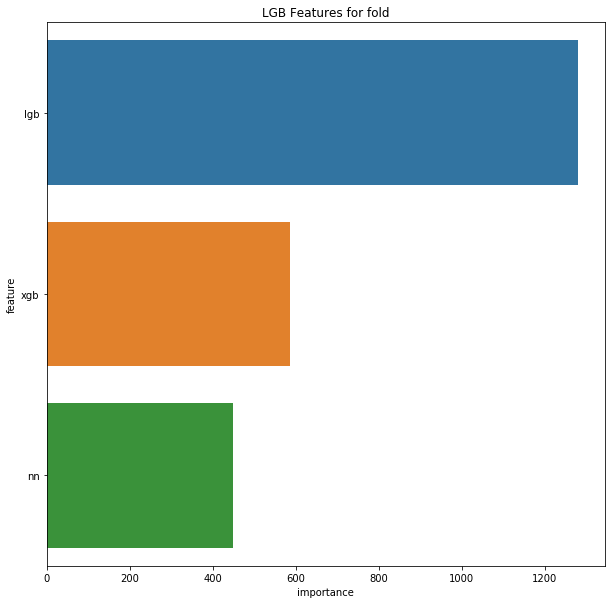


 Fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[516]	training's auc: 0.912953	valid_1's auc: 0.908214
Training took 0.07 minutes.


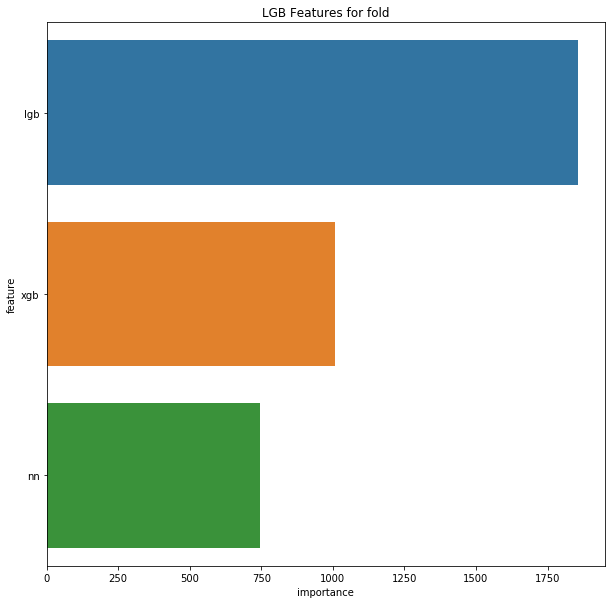


 Fold 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[326]	training's auc: 0.912457	valid_1's auc: 0.909238
Training took 0.05 minutes.


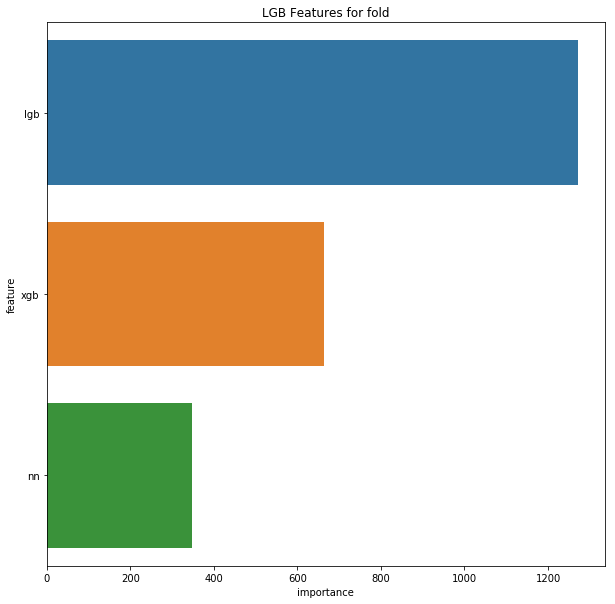

In [490]:
l1_res = train_and_test_model(level1_df, y, level1_df_test, level1_params, None, model_type='lgb')

In [537]:
roc_auc_score(y,l1_res['val_preds'])

0.90977579611214077

In [422]:
def create_submission(preds, sub_name='submission.csv'):
    sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
    sub_df["target"] = preds
    sub_df.to_csv(sub_name, index=False)

In [535]:
create_submission(0.8*lgb_res['test_preds']+0.2*nn_res['test_preds'])

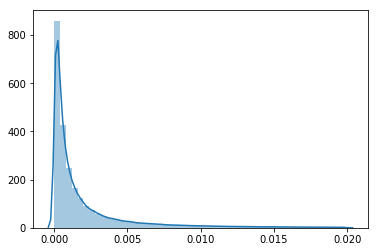

In [536]:
sns.distplot(0.01*lgb_res['test_preds']+0.01*nn_res['test_preds'])

In [ ]:
# r1 = X.sum(axis=1)
# r2 = X.median(axis=1)
# r3 = X.min(axis=1)
# r4 = X.max(axis=1)
# r5 = X.std(axis=1)
# r6 = X.apply(np.log).sum(axis=1)
# r8 = X.skew(axis=1)
# r9 = X.kurtosis(axis=1)

# X['row_sum'] = r1
# X['row_median'] = r2
# X['row_min'] = r3
# X['row_max'] = r4
# X['row_std'] = r5
# X['row_prod'] = r6
# X['row_skew'] = r8 
# X['row_kurt'] = r9

# r1 = X_test.sum(axis=1)
# r2 = X_test.median(axis=1)
# r3 = X_test.min(axis=1)
# r4 = X_test.max(axis=1)
# r5 = X_test.std(axis=1)
# r6 = X_test.apply(np.log).sum(axis=1)
# r8 = X_test.skew(axis=1)
# r9 = X_test.kurtosis(axis=1)

# X_test['row_sum'] = r1
# X_test['row_median'] = r2
# X_test['row_min'] = r3
# X_test['row_max'] = r4
# X_test['row_std'] = r5
# X_test['row_prod'] = r6
# X_test['row_skew'] = r8 
# X_test['row_kurt'] = r9
